Assignment 6: Convolutional Networks
====================================


Microsoft Forms Document: https://forms.office.com/r/89d0K2m5yr


Before we start, we should assure that we have activated CUDA -- otherwise training might take very long.
In Google Colaboratory:

1. Check the options Runtime -> Change Runtime Type on top of the page.
2. In the popup window, select hardware accelerator GPU.

Afterward, the following command should run successfully:

In [1]:
import torch
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  print("CUDA processing not available. Things will be slow :-(")

Successfully enabled CUDA processing


Task 1: Dataset Loading
-----------------------

Here, we use the MNIST dataset of handwritten digits for categorical classification.

Write a function that returns the training and the test set of MNIST, using the given transform.

In [2]:
import torch
import torchvision

def datasets(transform):
  trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
  testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

  return trainset, testset

Test 1: Data Types
------------------

Create the dataset with `transform=None`. Check that all inputs are of type `PIL.Image.Image`, and all targets are integral.

In [3]:
import PIL
trainset, testset = datasets(transform=None)

for x,t in trainset:
  # check datatype of input x
  assert isinstance(x,PIL.Image.Image)
  assert x.size == (28,28)
  # check datatype of target t
  assert isinstance(t,int) and 0<=t<=9
print("Data checking is finished successfully")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Data checking is finished successfully


Task 2: Data Loaders
--------------------

Create the dataset with `transform=torchvision.transforms.ToTensor()`. Create two data loaders, one for the training set and one for the test set. The training batch size should be $B=64$, for the test set, you can choose any batch size of your choice.


In [4]:
transform = torchvision.transforms.ToTensor()
trainset, testset = datasets(transform)

B = 64
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=B)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=B)

Test 2: Batches
---------------

Check that all batches generated by the training set data loader have the batch size of $B$ -- except for the last batch. Check that all inputs and targets are of type `torch.Tensor`. Check that all input values are in range $[0,1]$. Check that all target values are in range $[0,9]$.

In [5]:
for i, (x, t) in enumerate(trainloader):
  # check datatype, size and content of x
  assert type(x) == torch.Tensor
  assert torch.all(x >= 0) and torch.all(x <= 1)
  if (i != len(trainloader) - 1):
    assert len(x) == B

  # check datatype, size and content of t
  assert type(t) == torch.Tensor
  assert torch.all(t >= 0) and torch.all(t <= 9)

Task 3: Fully-Connected Network
-------------------------------

Implement a function that returns a three-layer fully-connected network in pytorch.
Use $\tanh$ as activation function between the two fully-connected layers, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.
Use the following layers:

1. A `torch.nn.Flatten` layer to turn the $28\times28$ pixel image (2D) into a $28*28$ pixel vector (1D)
2. A fully-connected layer with D input neurons and K outputs.
3. A $\tanh$ activation function.
4. A fully-connected layer with K input neurons and K outputs.
5. A $\tanh$ activation function.
6. A fully-connected layer with K input neurons and O outputs.

In [6]:
def fully_connected(D, K, O):
  return torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D,K),
    torch.nn.Tanh(),
    torch.nn.Linear(K,K),
    torch.nn.Tanh(),
    torch.nn.Linear(K,O),
  )

Task 4: Convolutions Output (theoretical question)
--------------------------------------------------

Consider the network as defined in Task 5.
Assume that the input is a $28\times28$ grayscale image.
How many hidden neurons do we need in the final fully-connected layer for a given number $Q_2$ of output channels of the second convolution?

\begin{aligned}
& \text{Given input size $28\times28$} \\
& \downarrow \\
& Q_1 \times 28 \times 28 \text{~ By Op.1. 2D convolutional layer with Q1 channels, kernel size 5 × 5, stride 1 and padding 2 } \\
& \downarrow \\
& Q_1 \times 14 \times 14 \text{~ By Op.2. 2Dmaximumpoolinglayerwithkernelsize2×2and stride 2} \\
& \downarrow \\
& Q_2 \times 14 \times 14 \text{~ By Op.3. tanh and Op.4. 2D convolutional layer with Q2 channels, kernel size
5 × 5, stride 1 and padding 2} \\
& \downarrow \\
& Q_2 \times 7 \times 7 \text{~ By Op.5. 2Dmaximumpoolinglayerwithkernelsize2×2and
stride 2 and Op.6. tanh} \\
& \downarrow \\
& Q_2 \cdot 7 \cdot 7 \rightarrow \text{the size of the flattened vector}
\end{aligned}



size after first convolution:\
Conv2 = $28\times28\times Q_1$

\
size after first MaxPool2D:\
MP2 = $(\frac{28}{kernel size}+2-strides)\times(\frac{28}{kernel size}+2-strides)\times Q_1$
\
MP2= $(\frac{28}{2}+2-2)\times(\frac{28}{2}+2-2)\times Q_1$
\
MP2 = $14\times14\times Q_1$

\
size after second convolution:\
Conv2 = $14\times14\times Q_2$

\
size after second MaxPool2D:\
MP2 = $(\frac{14}{kernel size}+2-strides)\times(\frac{14}{kernel size}+2-strides)\times Q_2$
\
MP2= $(\frac{14}{2}+2-2)\times(\frac{14}{2}+2-2)\times Q_2$
\
MP2 = $7\times7\times Q_2$


\
size after flatten:\
flatten1 = 7 * 7 * $Q_2$ = 49 * $Q_2$

\
Overall:
$(\frac{28}{2^2})\times(\frac{28}{2^2})\times Q_2$

Task 5: Convolutional Network
-----------------------------

Implement a function that generates a convolutional network wit the following layers:

1. 2D convolutional layer with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2.
2. 2D maximum pooling with pooling size $2\times2$ and stride 2
3. $\tanh$ activation
4. 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. 2D maximum pooling with pooling size $2\times2$ and stride 2
6. $\tanh$ activation
7. A flattening layer to turn the 3D image into 1D vector
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

In [7]:
def convolutional(Q1, Q2, O):
  return torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size = (5,5), stride=1, padding=2),
    torch.nn.MaxPool2d(kernel_size=(2,2), stride=2),
    torch.nn.Tanh(),
    torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size = (5,5), stride=1, padding=2),
    torch.nn.MaxPool2d(kernel_size=(2,2), stride=2),
    torch.nn.Tanh(),
    torch.nn.Flatten(),
    torch.nn.Linear(Q2*7*7, O)
  )


Task 6: Training and Validation Loop
------------------------------------

Implement a function that takes the network, the number of epochs and the learning rate.
Select the correct loss function for categorical classification, and SGD optimizer.
Iterate the following steps for the given number of epochs:

1. Train the network with all batches of the training data
2. Compute the test set loss and test set accuracy
3. Store both in a vector

What do we need to take care of?

Finally, return the lists of validation losses and accuracies.

In [8]:
def train(network, epochs=10, eta=0.01):
  # select loss function and optimizer
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params=network.parameters(), lr=eta)

  # instantiate the correct device
  device = torch.device("cuda")
  network = network.to(device)

  # collect loss values and accuracies over the training epochs
  val_loss, val_acc = [], []

  for epoch in range(epochs):
    # train network on training data
    for x,t in trainloader:
      optimizer.zero_grad()
      x = x.to(device)
      t = t.to(device)
      z = network(x)
      J = loss(z, t)
      J.backward()
      optimizer.step()

    # test network on test data
    with torch.no_grad():
      correct = 0
      test_loss = []
      for x,t in testloader:
        z = network(x.to(device))
        J = loss(z, t.to(device))
        # compute test accuracy
        correct += torch.sum(torch.argmax(z, dim=1) == t.to(device)).item()
        test_loss.append(J.item())
      acc = correct / len(testset)
      val_loss.append(sum(test_loss) / len(test_loss))
      val_acc.append(acc)

  # return loss and accuracy values
  return val_loss, val_acc

Task 7: Fully-Connected Training
--------------------------------

Create a fully-connected network with $K=10$ hidden and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$ and store the obtained test losses and accuracies.
Brave people can also train for 100 epochs (takes up to 30 minutes).

In [9]:
fc = fully_connected(28 * 28, 10, 10)
fc_loss, fc_acc = train(fc)

Task 8: Convolutional Training
------------------------------

Create a convolutional network with $Q_1=32$ and $Q_2=64$ convolutional channels and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$ and store the obtained test losses and accuracies.
Brave people can also train for 100 epochs (takes up to 30 minutes).

In [10]:
cv = convolutional(Q1=32, Q2=64, O=10)
cv_loss, cv_acc = train(cv)

Task 9: Plotting
----------------

Plot the two lists of loss values in one plot. Plot the two lists of accuracy values into another.

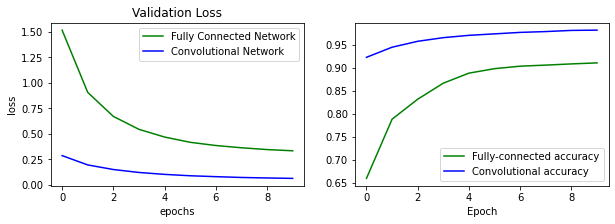

In [11]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,3))
ax = pyplot.subplot(121)
# plot loss values of FC and CV network over epochs
ax.plot(fc_loss, "g-", label="Fully Connected Network")
ax.plot(cv_loss, "b-", label="Convolutional Network")
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend()
ax.set_title('Validation Loss')

ax = pyplot.subplot(122)
# plot accuracy values of FC and CV network over epochs
ax.plot(fc_acc, "g-", label="Fully-connected accuracy")
ax.plot(cv_acc, "b-", label="Convolutional accuracy")
ax.set_xlabel("Epoch")
ax.legend()


Task 10: Learnable Parameters 
-----------------------------

Estimate roughly how many learnable parameters the two networks have by analytically computing and adding the number of parameters in each layer.
Compute the number of parameters in the networks by summing the number of parameters in each layer using pytorch functionality.
You can use the `numel()` function from a `torch.Tensor` to provide the number of (learnable) parameters stored in a tensor.

Fully connected network:
- for the first layer and second layer: there are (28*28+1)*10=7850 parameters;
- for the second layer and third layer: there are (10+1)*10=110 parameters;
- for the second layer and output layer: there are (10+1)*10=110 parameters.
- In total, 7850+110+110=8070

For convolutional network:
- for the first convolutional layer: there are 5*5*32=800 parameters;
- for the second convolutional layer: there are 64*32*5*5=51200 parameters;
- for flatten layer and output layer: there are (49*64+1)*10=31370 parameters;
In total, 800+51200+31370=83370.

In [12]:
def parameter_count(network):
  return sum(p.numel() for p in network.parameters())

print("Fully-connected Network:", parameter_count(fc))
print("Convolutional Network:", parameter_count(cv))

Fully-connected Network: 8070
Convolutional Network: 83466
